In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'       #Disactivate multiprocessing for numpy
import numpy as np
import matplotlib.pyplot as plt
import json
import gymnasium as gym
import yaml
from datetime import datetime

import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
from stable_baselines3 import PPO, A2C, SAC, TD3
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import EvalCallback, CallbackList, CheckpointCallback

from sogym.env import sogym
from sogym.mmc_optim import run_mmc
from sogym.env import sogym
from sogym.expert_generation import generate_expert_dataset, generate_mmc_solutions, generate_dataset
from sogym.utils import profile_and_analyze,ImageDictExtractor, CustomBoxDense
from sogym.callbacks import FigureRecorderCallback, MaxRewardCallback, GradientNormCallback
from sogym.pretraining import pretrain_agent, ExpertDataSet

import torch
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, Dataset

%load_ext autoreload
%autoreload 2

print('SB3 version:', stable_baselines3.__version__)
# Let's make the code device agnostic:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

SB3 version: 2.2.1
Using device: cuda


---
### Environment test and visualization:

In [2]:
# Let's test the environment using the check_env util from SB3:
observation_type = 'image'
train_env = sogym(mode='train',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity = True)
eval_env = sogym(mode='test',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity=False)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# It will check your custom environment and output additional warnings if needed
check_env(sogym(mode='train',observation_type='image'))

In [ ]:
# Example usage
# Specify the number of episodes to run
num_episodes = 20
# Call the profile_and_analyze function
result_df = profile_and_analyze(num_episodes, train_env)
# Print the resulting DataFrame
result_df

In [ ]:
obs = train_env.reset()
cfg = {
            'optimizer':'mma', #optimiser choice
            'xInt':0.25, #initial interval of components in x
            'yInt':0.25, #initial interval of components in y
            'E':1.0, #Young's modulus
            'nu':0.3, #Poisson ratio
            'h':1, #thickness
            'dgt0':5, #significant digit of sens.
            'scl':1, #scale factor for obj
            'p':6,  #power of super ellipsoid
            'lmd':100, #power of KS aggregation   
            'maxiter':500, # maximum number of outer iterations
            'alpha':1e-9, # This is the threshold level in the Heaviside function
            'epsilon':0.2, #This is the regularization term in the Heaviside function
            'maxinnerinit':1, # This is the maximum number of inner iterations for GCMMA
            'switch':-0.000002, # This is the switch criteria for the hybrid optimizer
            'convergence_threshold':2e-4, #This is the threshold for the relative change in the objective function
            'xmin':(0.0, 0.0, 0.0, 0.00, 0.00, -np.pi),
            'xmax':(train_env.dx, train_env.dy, 0.7*min(train_env.dx,train_env.dy), 0.05*min(train_env.dx,train_env.dy),0.05*min(train_env.dx,train_env.dy), np.pi)
        }

#run_mmc(train_env.conditions,train_env.nelx,train_env.nely,train_env.dx,train_env.dy,plotting='contour',verbose=0,cfg=cfg)
dataset_folder = "/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc"
#generate_mmc_solutions(key=0,dataset_folder="/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc")
generate_dataset(dataset_folder= dataset_folder, num_threads=32, num_samples=20000)

In [ ]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward==0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done,truncated, info = train_env.step(action)
        
# print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = axes.flatten()

# Initialize the index for the current subplot
subplot_index = 0

# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward == 0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done, truncated, info = train_env.step(action)
        
        # Plot the current observation image
        axes[subplot_index].imshow(obs['image'].T, cmap='gray')
        axes[subplot_index].axis('off')
        axes[subplot_index].set_title(f"Timestep {subplot_index+1}")
        
        # Increment the subplot index
        subplot_index += 1
        
        # If all subplots are filled, display the plot and reset the index
        if subplot_index == len(axes):
            plt.tight_layout()
            plt.show()
            subplot_index = 0

# Print the reward
print("Reward:", reward)

# Plot the final state of the training environment
train_env.plot()

# Display any remaining subplots
if subplot_index > 0:
    for i in range(subplot_index, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


In [3]:
# Specify the number of permutations to generate
num_permutations = 1
observation_type = "image"

# Specify the environment configuration (optional)
env_kwargs = {
    'mode': 'train',
    'observation_type': 'image',
    'vol_constraint_type': 'hard',
    'seed': 42
}

directory_path = "/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/dataset/topologies/mmc"
expert_observations, expert_actions = generate_expert_dataset(directory_path,env_kwargs, plot_terminated=False,num_permutations = None)
# Save the dataset
np.savez('expert_dataset.npz', expert_observations=expert_observations, expert_actions=expert_actions)
print(len(expert_observations))


Processing files:   7%|▋         | 1036/15773 [00:45<08:37, 28.48file/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))
Processing files:   7%|▋         | 1043/15773 [00:45<10:17, 23.86file/s]/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
Processing files:  17%|█▋        | 2753/15773 [01:59<09:06, 23.83file/s]/scratch/thomas/GitHub/sogym_v2/sogym/struct.py:42: RuntimeWarning: divide by zero encountered in divide
  temp = ((x1)**p)/((L**p)) + ((y1)**p)/((l**p))
Processing files:  17%|█▋        | 2758/15773 [01:59<10:47, 20.10file/s]/home/thomas/anaconda3/envs/SB3_update

7


<Figure size 640x480 with 0 Axes>

In [31]:
# Load the dataset when needed
dataset = np.load('expert_dataset.npz', allow_pickle=True)
expert_observations = dataset['expert_observations'].item()
expert_actions = dataset['expert_actions']


In [ ]:
# Assuming you have the expert_dataset defined
expert_dataset = ExpertDataSet(expert_observations, expert_actions, train_env)
# Get a random sample from the dataset
sample_idx = np.random.randint(len(expert_dataset))
sample = expert_dataset[sample_idx]

# Extract the observation and reward from the sample
observation, reward = sample
plt.imshow(observation['image'].T)

In [ ]:
import torch

# Clear the GPU memory
torch.cuda.empty_cache()

In [4]:
chosen_policy = "MlpPolicy" if observation_type == 'box_dense' else "MultiInputPolicy"

feature_extractor = ImageDictExtractor if observation_type == 'image' else CustomBoxDense

# Load the YAML file
env=train_env

with open("algorithms.yaml", "r") as file:
    config = yaml.safe_load(file)

# Extract the parameters for the desired algorithm
algorithm_name = "SAC"  # or "TD3"
algorithm_params = config[algorithm_name]

policy_kwargs = dict(
    features_extractor_class=feature_extractor,
    net_arch = config['common']['net_arch'],
    share_features_extractor = True
)

# Create the model based on the algorithm name and parameters
if algorithm_name == "SAC":
    model = SAC(env=env,
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device=device, 
                **algorithm_params)

elif algorithm_name == "PPO":
    model = PPO(env=env, 
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device = device, 
                **algorithm_params)

elif algorithm_name == "TD3":
    # Create the action noise object
    n_actions = env.action_space.shape[-1]
    action_noise_params = algorithm_params.pop("action_noise")
    action_noise = NormalActionNoise(mean=action_noise_params["mean"] * np.ones(n_actions),
                                     sigma=action_noise_params["sigma"] * np.ones(n_actions))
    model = TD3(env=env,
                policy =chosen_policy, 
                policy_kwargs=policy_kwargs,
                action_noise=action_noise,
                device=device, 
                **algorithm_params)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the tb_log_name string
tb_log_name = f"{algorithm_name}_{current_datetime}"

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorboard, torch.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/thomasrb/pretraining-rl/ff6f93b33072413ab58bcd9b0410ec1a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     grad_norm [3]  : (0.2499187713495297, 0.3665253675458635)
COMET INFO:     test_loss [3]  : (0.2874230887257616, 0.3264655173258829)
COMET INFO:     train_loss [3] : (0.29512603281983735, 0.3885317869653711)
COMET INFO:   Others:
COMET INFO:     Name : PPO_1
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-s

Train Epoch: 1 [1024/100947 (1%)]	Loss: 0.282153	Grad Norm: 0.284420	LR: 1.000000
Train Epoch: 1 [6144/100947 (6%)]	Loss: 0.285627	Grad Norm: 0.376257	LR: 1.000000
Train Epoch: 1 [11264/100947 (11%)]	Loss: 0.284955	Grad Norm: 0.425972	LR: 1.000000
Train Epoch: 1 [16384/100947 (16%)]	Loss: 0.277639	Grad Norm: 0.280182	LR: 1.000000
Train Epoch: 1 [21504/100947 (21%)]	Loss: 0.302614	Grad Norm: 0.472926	LR: 1.000000
Train Epoch: 1 [26624/100947 (26%)]	Loss: 0.291578	Grad Norm: 0.340468	LR: 1.000000
Train Epoch: 1 [31744/100947 (31%)]	Loss: 0.288882	Grad Norm: 0.390437	LR: 1.000000
Train Epoch: 1 [36864/100947 (36%)]	Loss: 0.274558	Grad Norm: 0.949690	LR: 1.000000
Train Epoch: 1 [41984/100947 (41%)]	Loss: 0.290247	Grad Norm: 0.278979	LR: 1.000000
Train Epoch: 1 [47104/100947 (46%)]	Loss: 0.298649	Grad Norm: 0.419342	LR: 1.000000
Train Epoch: 1 [52224/100947 (52%)]	Loss: 0.285119	Grad Norm: 0.379363	LR: 1.000000
Train Epoch: 1 [57344/100947 (57%)]	Loss: 0.283812	Grad Norm: 0.430232	LR: 1.000

KeyboardInterrupt: 

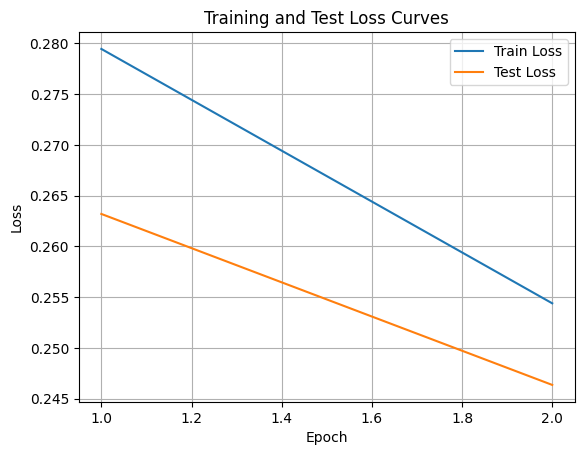

In [6]:
pretrain_agent(
    model,
    expert_observations,
    expert_actions,
    env,
    test_env = eval_env,
    batch_size=1024,
    epochs=100,
    scheduler_gamma=0.98,
    learning_rate=1.0,
    log_interval=5,
    no_cuda=False,
    seed=1,
    verbose=True,
    test_batch_size=512,
    early_stopping_patience=300,
    plot_curves=True,
    tensorboard_log_dir="tb_logs/imitation",
    save_path="checkpoints/imitation_SAC",
    comet_ml_api_key="No20MKxPKu7vWLOUQCFBRO8mo",
    comet_ml_project_name="pretraining_rl",
    comet_ml_experiment_name="PPO_1",
    eval_freq = 5,
    l2_reg_strength=0.00001,

)

---
### Multiprocessing

In [ ]:
#from transformers import AutoTokenizer, AutoModel
from stable_baselines3.common.vec_env import DummyVecEnv, VecCheckNan
import multiprocessing

#tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")
#model = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1").to('cuda')

# Set number of cpus to use automatically:
num_cpu = multiprocessing.cpu_count()

print("Using {} cpus!".format(num_cpu))
observation_type = "image"

train_env = sogym(mode='train',observation_type=observation_type,vol_constraint_type = 'hard',resolution=50,check_connectivity=True)#,model=model,tokenizer=tokenizer)
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env = VecCheckNan(env, raise_exception=True)
#env=VecNormalize(env,gamma=1.0)

eval_env = sogym(mode='test',observation_type=observation_type,vol_constraint_type='hard',resolution=50,check_connectivity=True)#,model=model,tokenizer=tokenizer)
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
#eval_env =VecNormalize(eval_env,gamma=1.0)


--- 
### Defining the model

In [ ]:

# Create the model based on the algorithm name and parameters
if algorithm_name == "SAC":
    model = SAC(env=env,
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device=device, 
                **algorithm_params)

elif algorithm_name == "PPO":
    model = PPO(env=env, 
                policy = chosen_policy, 
                policy_kwargs=policy_kwargs,
                device = device, 
                **algorithm_params)

elif algorithm_name == "TD3":
    # Create the action noise object
    n_actions = env.action_space.shape[-1]
    action_noise_params = algorithm_params.pop("action_noise")
    action_noise = NormalActionNoise(mean=action_noise_params["mean"] * np.ones(n_actions),
                                     sigma=action_noise_params["sigma"] * np.ones(n_actions))
    model = TD3(env=env,
                policy =chosen_policy, 
                policy_kwargs=policy_kwargs,
                action_noise=action_noise,
                device=device, 
                **algorithm_params)

# Get the current date and time
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create the tb_log_name string
tb_log_name = f"{algorithm_name}_{current_datetime}"

In [ ]:
# Save a checkpoint every 1000 steps
checkpoint_callback = CheckpointCallback(
  save_freq=5000//num_cpu,
  save_path="./checkpoints/",
  name_prefix=tb_log_name,
  save_replay_buffer=True,
  save_vecnormalize=True,
)

eval_callback = EvalCallback(eval_env,
                             log_path='tb_logs',
                             eval_freq=5000//num_cpu,
                             deterministic=True,
                            n_eval_episodes=10,
                             render=False,
                             best_model_save_path='./checkpoints',
                             verbose=0)



callback_list = CallbackList([eval_callback,
                         checkpoint_callback,
                         MaxRewardCallback(verbose=1),
                         GradientNormCallback(verbose=1),
                         FigureRecorderCallback(check_freq=5000//num_cpu,eval_env=eval_env)
                         ])

--- 
### Training

Save the model:

If model is on-policy:
#model.save("sac_pendulum")
#loaded_model = SAC.load("sac_pendulum")

if model is off-policy, we also need to save the replay buffer:
#model.save_replay_buffer("sac_replay_buffer")
#loaded_model.load_replay_buffer("sac_replay_buffer")

If the environment is normalized:
#env.save('env_saved.pkl')
#env = VecNormalize.load('env_saved.pkl',env)


In [ ]:
#model = SAC.load("checkpoints/imitation_SAC",env =env) #Saved model is with soft volume constraint and 75 r
model.set_parameters("checkpoints/imitation_SAC.zip")
#print(model.batch_size)
#model.load_replay_buffer("sac_replay_buffer")
model.learn(20000000,
            callback=callback_list, 
            tb_log_name=tb_log_name
            )
#model.save('model_saved_march15',)
#model.save_replay_buffer("sac_replay_buffer_march15")

#env.save('env_saved.pkl')

---
### Let's visualize the agent's performance:

In [6]:
env=sogym(mode='train',observation_type='image',vol_constraint_type='hard' ,resolution = 50)
#env= make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env

<Figure size 1000x1000 with 0 Axes>

[-0.47340894 -0.4943142   0.24323463 -0.21771634 -0.9230222  -0.8357469 ]
[-0.36565638 -0.41008818  0.2326765  -0.30187762 -0.7953548  -0.5590747 ]
[-0.5997746  -0.41025054 -0.12160712 -0.33384824 -0.8629772  -0.8306467 ]
[-0.77703476 -0.15383506 -0.32884187  0.36240637 -0.83225554 -0.82141554]
[-0.890426    0.3816849  -0.28132343  0.19995654 -0.6774317  -0.71891403]
[-0.7113625  -0.33434224  0.42188466 -0.37141168 -0.79973924 -0.8092761 ]
[-0.63109004 -0.21109915  0.6860552  -0.66002536 -0.7980732  -0.90163577]
[-0.4744836   0.511467    0.59999347  0.26720238 -0.8784219  -0.93474036]
Desired volume: 0.34 Obtained volume: 0.051269734598689824


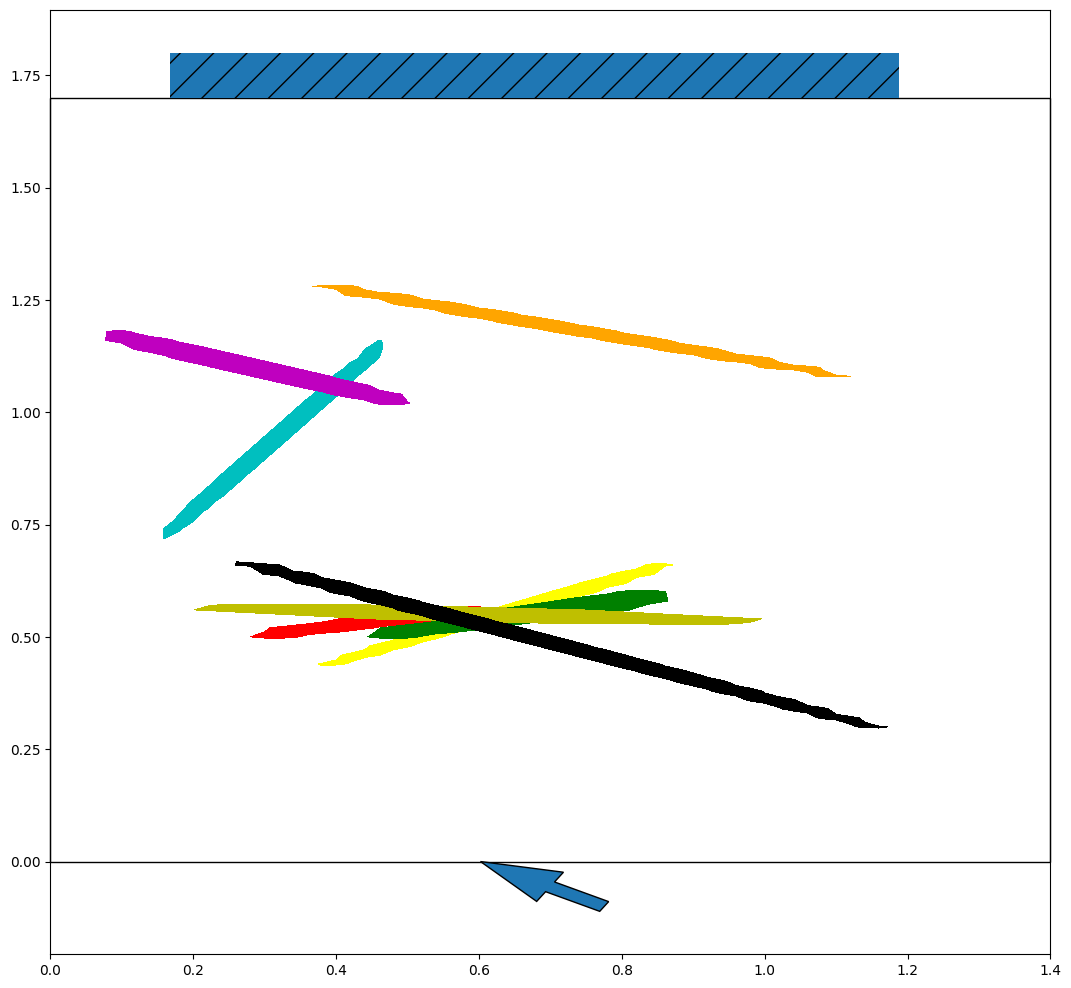

In [7]:
obs,info=env.reset()
dones=False
saved_conditions = env.conditions
saved_nelx, saved_nely = env.nelx, env.nely
saved_dx, saved_dy = env.dx, env.dy
#use deepcopy to save 
while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    print(action)
    obs, rewards, dones,truncated, info = env.step(action)
print("Desired volume:",saved_conditions['volfrac'],"Obtained volume:",env.volume)
#print("Env reward:",rewards, "Compliance:",np.exp(1/rewards))
env.plot()

In [ ]:
xval, f0val,it, H, Phimax, allPhi, den, N, cfg = run_mmc(saved_conditions,saved_nelx,saved_nely,saved_dx,saved_dy,plotting='contour')